# Imports

In [1]:
import numpy as np
from glob import glob
import torch
import os, sys, time, csv
import re
import random
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as ipyw
import inspect
import pickle
%matplotlib inline

# Process image stacks into feature vector matrices using pre-trained model (for LSTM input).

In [2]:
# Torch imports.
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision.models.resnet

# Visualization imports
from IPython import display
os.getcwd()

'/home/ubuntu/src/YPB-AI/Script'

In [3]:
# Part A: Load in model pre-trained on individual images. Note that pre-training may not even be necessary, as I was only
# changing the weights on the last (new) fully connected layer, and that layer will likely be gotten rid of. 
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
del model.classifier

# Assemble image pathnames and understand class breakdown in dataset

In [4]:
# Note down train, validation and test directories.
topDir = '../afterSplit/MM_DNN/Training'
# topDir = 'Split_Data_5_11_2019_MM_DNN'

saveName = 'LSTM_050220' ## CHANGE THIS WHEN TRAIN A NEW MODEL!!!!!

train_dir = topDir + "/train"
valid_dir = topDir + "/valid"
test_dir = topDir + "/test"
# test_dir = 'Bam1_no_pillBottle'

# Check quantities of train, validation and test images
train_images = np.array(glob(train_dir + "/*/*"))
valid_images = np.array(glob(valid_dir + "/*/*"))
test_images = np.array(glob(test_dir + "/*/*"))

# Check relative percentages of image types
train_images_absent = np.array(glob(train_dir + "/Absent/*"))
train_images_present = np.array(glob(train_dir + "/Present/*"))

valid_images_absent = np.array(glob(valid_dir + "/Absent/*"))
valid_images_present = np.array(glob(valid_dir + "/Present/*"))

test_images_absent = np.array(glob(test_dir + "/Absent/*"))
test_images_present = np.array(glob(test_dir + "/Present/*"))

num_train_images = len(train_images)
num_valid_images = len(valid_images)
num_test_images = len(test_images)

print("There are {} training stacks, {} validation stacks and {} test stacks.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(train_images_present)/len(train_images)*100, pos2=len(train_images_present),neg=len(train_images_absent)/len(train_images)*100, neg2=len(train_images_absent)))
print("For the validation stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(valid_images_present)/len(valid_images)*100, pos2=len(valid_images_present),neg=len(valid_images_absent)/len(valid_images)*100, neg2=len(valid_images_absent)))
print("For the test stacks, {pos:=.1f}% ({pos2}) are positive and {neg:=.1f}% ({neg2}) are negative.".format(pos=len(test_images_present)/len(test_images)*100, pos2=len(test_images_present),neg=len(test_images_absent)/len(test_images)*100, neg2=len(test_images_absent)))

There are 9123 training stacks, 1141 validation stacks and 1141 test stacks.
For the training stacks, 50.1% (4574) are positive and 49.9% (4549) are negative.
For the validation stacks, 50.1% (572) are positive and 49.9% (569) are negative.
For the test stacks, 50.1% (572) are positive and 49.9% (569) are negative.


In [5]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

In [6]:
# Check to see how many GPUs are available.
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    num_devices = torch.cuda.device_count()
    print("{} GPUs found.".format(num_devices))
else:
    num_devices = 0

1 GPUs found.


# Plot sample image stacks

In [7]:
# Following https://github.com/mohakpatel/ImageSliceViewer3D, with modifications for plotting multiple stacks of color images. 
class ImageSliceViewer:
    """ 
    ImageSliceViewer is for viewing image stacks in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image.

    Argumentss:
    Volume = stack of color input images [num images, height, width, RGB]
    figsize = default(8,8), to set the size of the figure
    
    """
    
    def __init__(self, volume, figsize=(10,10)):
        self.volume = volume
        self.figsize = figsize
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
            options=['x-y'], value='x-y', 
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))
    
    def view_selection(self, view):
        # View the volume
        maxZ = self.volume.shape[0] - 1
        
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, 
            z=ipyw.IntSlider(min=0, max=maxZ, step=1, continuous_update=False, 
            description='Image Slice:'))
        
    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        fig=plt.figure(figsize=self.figsize)
        plt.imshow(self.volume[z,:,:,:], 
            vmin=self.v[0], vmax=self.v[1])
# ''';

In [8]:
def show_an_image_stack(dataset):
    fig = plt.figure(figsize = (10,10))
    axes = []
    # Grab a stack at random and build a volume.
    directories = os.listdir(dataset)
    directory = directories[np.random.randint(0,len(directories)-1)]
    files = os.listdir(os.path.join(dataset,directory))
    print("Plotting image stack {}".format(os.path.join(dataset,directory)))
    files.sort()
    imgArr = []
    for file in files:
        file = os.path.join(dataset,directory, file)
        file = pickle.load(file)
        imgArr.append(np.array(Image.open(file)))
    imgArr = np.array(imgArr)
    # Plot the volume within a subplot
    ImageSliceViewer(imgArr)
# ''';

In [9]:
# show_an_image_stack('Split_Data/train/Present')

# Imports for torch and DALI functions

In [7]:
# Define the model
class MM_DNN(nn.Module):
    def __init__(self, drop_prob=0.2, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.lr = lr
        
        self.dropout = nn.Dropout(drop_prob)
        
        self.fc = nn.Linear(4*1024,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,2)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
        x = x.view(-1)
        out = self.dropout(self.relu(self.fc(x)))
        out = self.dropout(self.relu(self.fc2(out)))
        out = self.fc3(out)
        # return the final output
        return out

In [34]:
# Define the model
# From Amazon sentiment analysis https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

class MM_LSTM(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(MM_LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # self.embedding = nn.Embedding(vocab_size, embedding_dim) embedding_dim = 1024; we don't need vocab_size
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        # print(x.is_cuda)
        # x = x.long()
        # embeds = self.embedding(x)
        # Embedding dimension: [batch_size, # words in sequence, embedding dimension]
        # x has to be of the shape above
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

# https://github.com/tqxg2018/Image-Caption-Pytorch/blob/4686b5a34ce03598edfc5ac4b738724b46755f64/train-traditional.py    
class MM_LSTM2(nn.Module): # imgs, caps, caplens embed_size = 1024, hidden_size = 1, vocab_size = 2, i thinkg
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout = 0.5): #512 512 9490 1 
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.decode_step = nn.LSTMCell(embed_size, hidden_size, bias=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=self.dropout)

    def forward(self, images, captions, length):
        
        batch_size = images.size(0) #64
        vocab_size = self.vocab_size #vocab size
        
        caption_lengths, sort_ind = length.squeeze(1).sort(dim=0, descending=True)
        features = images[sort_ind] #2048
        captions = captions[sort_ind] #512
        
        embeddings = self.embedding(captions)
        decode_lengths = (caption_lengths - 1).tolist()
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        h, c = self.decode_step(features)  # (batch_size_t, decoder_dim)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            h, c = self.decode_step(embeddings[:batch_size_t, t, :], (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
        
        return predictions, captions, decode_lengths, sort_ind
    
# Keras
# def lstm(self):
#         """Build a simple LSTM network. We pass the extracted features from
#         our CNN to this model predomenently."""
#         # Model.
#         model = Sequential()
#         model.add(LSTM(2048, return_sequences=False,
#                        input_shape=self.input_shape,
#                        dropout=0.5))
#         model.add(Dense(512, activation='relu'))
#         model.add(Dropout(0.5))
#         model.add(Dense(self.nb_classes, activation='softmax'))

In [9]:
# class DatasetFolderWithPaths(datasets.DatasetFolder):
#     """Custom dataset that includes image file paths. Extends
#         torchvision.datasets.ImageFolder
#     """
#     # override the __getitem__ method. this is the method that dataloader calls
#     def __getitem__(self, index):
#     # this is what ImageFolder normally returns 
#         original_tuple = super(DatasetFolderWithPaths, self).__getitem__(index)
#         # the image file path
#         path = self.samples[index][0]
#         # make a new tuple that includes original and the path
#         tuple_with_path = (original_tuple + (path,))
#         return tuple_with_path

In [15]:
# Use the PyTorch data loader here, way easier. 
def load_pickle(path):
    with open(path,'rb') as f:
        return pickle.load(f)
    

batch_size = 32

train_data = datasets.DatasetFolder(train_dir,load_pickle,'.pickle')
validation_data = datasets.DatasetFolder(valid_dir,load_pickle,'.pickle')
test_data = datasets.DatasetFolder(test_dir,load_pickle,'.pickle')
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, num_workers=num_devices*4, pin_memory=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_devices*4, pin_memory=True)


In [11]:
x = load_pickle('/home/ubuntu/src/YPB-AI/afterSplit/MM_DNN/Training/valid/Absent/XS_Negative_Dark_14-Mar-2019_18-53-16.pickle')
len(x[3][0])
image, label = iter(train_loader).next()
# print(train_data)
x.shape
# test_loader.dataset.samples[0]

torch.Size([12, 1, 1024])

In [26]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)
    break
# train_loader
inputs = inputs[:,0:4,:,:]
print(inputs)
inputs = inputs.view(batch_size, 4, 1024)
print(inputs.shape)
print(inputs)

torch.Size([32, 12, 1, 1024])
torch.Size([32])
tensor([[[[4.9562e-04, 4.5940e-05, 9.2659e-03,  ..., 0.0000e+00,
           6.6864e-01, 3.5838e-02]],

         [[5.1662e-04, 2.9830e-05, 9.3807e-03,  ..., 0.0000e+00,
           6.8016e-01, 3.4868e-02]],

         [[5.3690e-04, 3.7869e-05, 9.3837e-03,  ..., 0.0000e+00,
           6.8554e-01, 3.5660e-02]],

         [[5.5060e-04, 2.8297e-05, 9.4092e-03,  ..., 0.0000e+00,
           6.4830e-01, 2.9745e-02]]],


        [[[2.2346e-04, 3.7350e-04, 5.7384e-03,  ..., 2.4841e-02,
           1.0203e+00, 1.7571e-01]],

         [[2.2881e-04, 2.2222e-04, 5.3729e-03,  ..., 7.2025e-02,
           1.0397e+00, 1.8094e-01]],

         [[2.4653e-04, 2.0222e-04, 4.9996e-03,  ..., 3.7047e-02,
           1.0398e+00, 2.6392e-01]],

         [[2.4289e-04, 1.4478e-04, 5.0125e-03,  ..., 5.1573e-02,
           7.9861e-01, 3.4844e-01]]],


        [[[2.2770e-04, 3.4909e-03, 6.6225e-03,  ..., 0.0000e+00,
           9.2392e-01, 8.2179e-01]],

         [[2.6082e-04,

In [36]:
output_size = 1
embedding_dim = 1024
hidden_dim = 512
n_layers = 2
num_images_in_seq = 4

model = MM_LSTM(output_size, embedding_dim, hidden_dim, n_layers)
if use_cuda:
    model.cuda()

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 50
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf
valid_batch = 1
model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        # Change inputs dimension to [batch_size, # words in sequence, embedding dimension]
        # inputs = inputs[0:4] # Can try increase this to compare; original = 4 
        inputs = inputs[:,0:num_images_in_seq,:,:]
        inputs = inputs.view(batch_size, num_images_in_seq, embedding_dim)
        
        if(use_cuda):
            inputs, labels = inputs.cuda(), labels.cuda()
        counter += 1
        h = tuple([e.data for e in h])
        # inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        # print(inputs.is_cuda)
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in valid_loader:
                inp = inp[:,0:num_images_in_seq,:,:]
                inp = inp.view(batch_size, num_images_in_seq, embedding_dim)
                val_h = tuple([each.data for each in val_h])
                # inp, lab = inp.to(device), lab.to(device)
                if(use_cuda):
                    inp, lab = inp.cuda(), lab.cuda()
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt') # Fix this lol
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

Epoch: 22/50... Step: 6000... Loss: 0.136513... Val Loss: 0.169762
Validation loss decreased (inf --> 0.169762).  Saving model ...
Epoch: 43/50... Step: 12000... Loss: 0.536685... Val Loss: 0.147646
Validation loss decreased (0.169762 --> 0.147646).  Saving model ...


In [64]:
type(inputs.type(torch.cuda.LongTensor))

torch.Tensor

In [41]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

test_losses = []
num_correct = 0
h = model.init_hidden(batch_size)

model.eval()
for inputs, labels in test_loader:
    h = tuple([each.data for each in h])
    inputs = inputs[:,0:num_images_in_seq,:,:]
    try:
        inputs = inputs.view(batch_size, num_images_in_seq, embedding_dim)
    except:
        continue # last batch has less than 32 images
    if(use_cuda):
        inputs, labels = inputs.cuda(), labels.cuda()
    output, h = model(inputs, h)
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

# Check false positives, negatives

Test loss: 0.113
Test accuracy: 94.479%


In [68]:
def train(net, train_loader, epochs=10, batch_size=2, lr=0.001, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: DNN network
        train_loader: PyTorch dataloader containing data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        lr: learning rate
        print_every: Number of steps for printing training and validation loss
    
    '''
    valid_batch = 1
    net.train()
    
    output_size = 1
    embedding_dim = 1024
    hidden_dim = 512
    n_layers = 1
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    
    running_loss = 0.
    
    
    if(use_cuda):
        net.cuda()
    all_valid_losses = [.6]
    counter = 0
    for e in range(epochs):
        
        for batch_idx, batch_data in enumerate(train_loader):
            inputs = batch_data[0].view(12,batch_size,1024)
            inputs = inputs[0:4] # Can try increase this to compare; original = 4 
            
            input_size = len(inputs)
            targets = batch_data[1]
            if(use_cuda):
                inputs, targets = inputs.cuda(), targets.cuda()
            # zero accumulated gradients
            net.zero_grad()
            # get the output from the model
            output = net(inputs)
            # calculate the loss and perform backprop
            loss = criterion(output.view(batch_size,2), targets)
            loss.backward()
            opt.step()
            running_loss += loss.item()
            
            # loss stats
            if batch_idx % print_every == 0:
                # Get validation loss
                val_losses = []
                train_losses = []
                net.eval()
                correct = 0.
                total = 0.
                for val_batch_idx, batch_data in enumerate(valid_loader):                    
                    inputs, targets = batch_data[0].view(12,valid_batch,1024), batch_data[1]
                    inputs = inputs[0:4]
                    
                    if(use_cuda):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output = net(inputs)
                    # print(output)
                    
                    val_loss = criterion(output.view(valid_batch,2), targets)
                    val_losses.append(val_loss.item()/len(valid_loader))
                    
                    train_losses.append(running_loss/len(train_loader))
                    
                    pred = output.max(0,keepdim=True)[1]
                    # print(pred)
                    
                    # compare predictions to true label
                    correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
                    total += valid_batch
                
                net.train() # reset to train mode after iteration through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(batch_idx),
                      "Loss: {:.8f}...".format(loss.item()),
                      "Val Loss: {:.4f}...".format(np.mean(val_losses)),
                      "Val Accuracy: {:.1f}%".format(correct/total*100))
                
                if np.mean(val_losses) < np.min(all_valid_losses):
                    print("Validation loss dropped, saving model.")
                    torch.save(net,'DNNModel_' + saveName + '.pt')
                    all_valid_losses = np.append(all_valid_losses,np.mean(val_losses))

In [69]:
# define and print the net

net = MM_DNN()
#net = MM_LSTM(32,1)
print(net)

MM_DNN(
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


In [70]:
train(net,train_loader,50,1,print_every=6000,lr=0.0001)

Epoch: 1/50... Step: 0... Loss: 0.81979024... Val Loss: 0.0006... Val Accuracy: 50.8%
Validation loss dropped, saving model.


/home/ubuntu/anaconda3/envs/derm-ai/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MM_DNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/50... Step: 6000... Loss: 0.00855243... Val Loss: 0.0003... Val Accuracy: 84.8%
Validation loss dropped, saving model.
Epoch: 2/50... Step: 0... Loss: 0.03266120... Val Loss: 0.0002... Val Accuracy: 87.5%
Validation loss dropped, saving model.
Epoch: 2/50... Step: 6000... Loss: 2.26924348... Val Loss: 0.0002... Val Accuracy: 90.8%
Validation loss dropped, saving model.
Epoch: 3/50... Step: 0... Loss: 0.14726210... Val Loss: 0.0002... Val Accuracy: 92.6%
Validation loss dropped, saving model.
Epoch: 3/50... Step: 6000... Loss: 0.17468941... Val Loss: 0.0002... Val Accuracy: 92.1%
Epoch: 4/50... Step: 0... Loss: 0.01068306... Val Loss: 0.0001... Val Accuracy: 93.3%
Validation loss dropped, saving model.
Epoch: 4/50... Step: 6000... Loss: 0.00162292... Val Loss: 0.0001... Val Accuracy: 93.2%
Validation loss dropped, saving model.
Epoch: 5/50... Step: 0... Loss: 0.01067328... Val Loss: 0.0001... Val Accuracy: 93.9%
Validation loss dropped, saving model.
Epoch: 5/50... Step: 6000..

Epoch: 45/50... Step: 0... Loss: 0.00000000... Val Loss: 0.0001... Val Accuracy: 96.9%
Epoch: 45/50... Step: 6000... Loss: 0.00346172... Val Loss: 0.0001... Val Accuracy: 95.9%
Epoch: 46/50... Step: 0... Loss: 0.00000000... Val Loss: 0.0001... Val Accuracy: 96.9%
Epoch: 46/50... Step: 6000... Loss: 0.00246668... Val Loss: 0.0001... Val Accuracy: 96.6%
Epoch: 47/50... Step: 0... Loss: 0.00002480... Val Loss: 0.0001... Val Accuracy: 96.2%
Epoch: 47/50... Step: 6000... Loss: 0.00002789... Val Loss: 0.0001... Val Accuracy: 96.2%
Epoch: 48/50... Step: 0... Loss: 0.00003052... Val Loss: 0.0001... Val Accuracy: 97.0%
Validation loss dropped, saving model.
Epoch: 48/50... Step: 6000... Loss: 0.00055313... Val Loss: 0.0001... Val Accuracy: 96.7%
Epoch: 49/50... Step: 0... Loss: 0.00058079... Val Loss: 0.0001... Val Accuracy: 96.9%
Epoch: 49/50... Step: 6000... Loss: 0.00000668... Val Loss: 0.0001... Val Accuracy: 96.7%
Epoch: 50/50... Step: 0... Loss: 0.00027847... Val Loss: 0.0001... Val Accur

In [52]:
# Plot learning curve
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

NameError: name 'train_losses' is not defined

In [71]:
# saveName = 'Testing'
net = torch.load('DNNModel_' + saveName + '.pt')
stateDictName ='DNN_StateDict_' + saveName + '.pt'

In [73]:
torch.save(net.state_dict(), stateDictName)
saveName

'Testing_Bam_all_no_pillBottle_DenseNet'

In [74]:
net.load_state_dict(torch.load(stateDictName))

In [13]:
# Test data
print(test_loader)

def test(net, test_loader):
    net.eval()
    correct = 0.
    total = 0.
    test_batch = 1
    test_losses = []
    criterion = nn.CrossEntropyLoss()
    for test_batch_idx, batch_data in enumerate(test_loader):   
        inputs, targets = batch_data[0].view(12,test_batch,1024), batch_data[1]
        inputs = inputs[0:4]

        if(use_cuda):
            inputs, targets = inputs.cuda(), targets.cuda()
            
        # print(inputs)
        output = net(inputs)

        test_loss = criterion(output.view(test_batch,2), targets)
        test_losses.append(test_loss.item()/len(test_loader))

        pred = output.max(0,keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += test_batch
        
    print("Test Loss: {:.8f}...".format(np.mean(test_losses)),
      "Test Accuracy: {:.1f}%".format(correct/total*100))
# plt.imshow(torchvision.utils.make_grid(images))

# outputs = net(images)

In [23]:
test(net, test_loader)

[tensor([[[[3.4960e-04, 9.0719e-05, 8.7857e-03,  ..., 0.0000e+00,
           1.2114e+00, 5.9370e-02]],

         [[3.4907e-04, 9.5218e-05, 8.7631e-03,  ..., 0.0000e+00,
           1.2012e+00, 5.9925e-02]],

         [[3.6396e-04, 1.5849e-04, 8.6784e-03,  ..., 0.0000e+00,
           1.0425e+00, 5.6684e-02]],

         ...,

         [[3.5635e-04, 1.4943e-04, 8.7291e-03,  ..., 0.0000e+00,
           1.1092e+00, 5.2642e-02]],

         [[3.4882e-04, 1.1206e-04, 8.9095e-03,  ..., 0.0000e+00,
           1.0733e+00, 6.4219e-02]],

         [[3.5719e-04, 1.1797e-04, 8.9816e-03,  ..., 0.0000e+00,
           9.8060e-01, 5.5792e-02]]]]), tensor([0])]
[tensor([[[[1.5751e-04, 1.9372e-04, 2.0220e-03,  ..., 1.9875e-01,
           1.7361e-02, 0.0000e+00]],

         [[3.5532e-04, 7.0684e-05, 8.5080e-03,  ..., 0.0000e+00,
           8.5761e-01, 1.8631e-04]],

         [[3.4998e-04, 1.0555e-04, 8.6151e-03,  ..., 0.0000e+00,
           8.8079e-01, 7.3884e-03]],

         ...,

         [[4.1094e-04, 2.7

[tensor([[[[6.1135e-04, 1.4389e-03, 4.0225e-03,  ..., 1.6961e-02,
           1.0776e+00, 9.1646e-02]],

         [[5.8582e-04, 1.1453e-03, 4.2937e-03,  ..., 0.0000e+00,
           1.3331e+00, 1.2774e-01]],

         [[6.3335e-04, 1.1806e-03, 3.6169e-03,  ..., 1.4840e-02,
           8.6916e-01, 4.8301e-02]],

         ...,

         [[5.9027e-04, 3.5867e-04, 5.2100e-03,  ..., 1.5139e-02,
           3.3932e-01, 5.7797e-02]],

         [[6.1694e-04, 7.4335e-04, 5.0846e-03,  ..., 1.0608e-02,
           7.6661e-01, 2.5114e-02]],

         [[5.6949e-04, 6.6504e-04, 4.0532e-03,  ..., 4.3362e-02,
           6.0614e-01, 8.3119e-04]]]]), tensor([0])]
[tensor([[[[6.4345e-04, 1.1105e-03, 3.9114e-03,  ..., 7.4574e-02,
           9.1842e-01, 9.4422e-02]],

         [[6.1100e-04, 1.1880e-03, 4.4451e-03,  ..., 5.9013e-03,
           1.2634e+00, 1.0530e-01]],

         [[6.4974e-04, 1.2503e-03, 3.8887e-03,  ..., 1.7337e-02,
           7.8095e-01, 3.4256e-02]],

         ...,

         [[5.9995e-04, 5.4

[tensor([[[[3.8103e-04, 3.3579e-04, 5.7726e-03,  ..., 3.9698e-02,
           8.1209e-01, 3.1133e-01]],

         [[3.6315e-04, 4.1880e-04, 5.4005e-03,  ..., 3.0052e-02,
           6.9796e-01, 2.6992e-01]],

         [[4.0787e-04, 3.5535e-04, 5.2373e-03,  ..., 2.0995e-02,
           7.3068e-01, 2.5859e-01]],

         ...,

         [[3.9321e-04, 3.9589e-04, 5.3541e-03,  ..., 3.3334e-02,
           6.6985e-01, 1.6809e-01]],

         [[3.9528e-04, 4.4652e-04, 5.2629e-03,  ..., 3.7979e-02,
           7.4188e-01, 1.3721e-01]],

         [[4.0009e-04, 5.1453e-04, 5.3601e-03,  ..., 1.4718e-02,
           6.9783e-01, 2.5794e-01]]]]), tensor([0])]
[tensor([[[[2.7114e-04, 1.0354e-03, 1.5710e-03,  ..., 3.6141e-01,
           5.8299e-02, 0.0000e+00]],

         [[2.7252e-04, 1.0642e-03, 1.8521e-03,  ..., 2.3909e-01,
           3.3110e-02, 0.0000e+00]],

         [[2.5242e-04, 9.1366e-04, 1.6833e-03,  ..., 2.5643e-01,
           3.0141e-02, 0.0000e+00]],

         ...,

         [[3.1300e-04, 1.2

[tensor([[[[4.6302e-04, 8.4145e-04, 5.7972e-03,  ..., 8.2663e-02,
           5.1158e-01, 5.6530e-01]],

         [[4.6706e-04, 7.9345e-04, 5.8562e-03,  ..., 8.9411e-02,
           5.4797e-01, 3.9937e-01]],

         [[4.5710e-04, 7.3726e-04, 5.7563e-03,  ..., 8.1040e-02,
           4.9549e-01, 5.3958e-01]],

         ...,

         [[4.5388e-04, 7.4245e-04, 5.7309e-03,  ..., 1.1317e-01,
           5.1665e-01, 4.7751e-01]],

         [[4.5777e-04, 7.4505e-04, 5.6987e-03,  ..., 6.7639e-02,
           5.4269e-01, 5.6890e-01]],

         [[4.5680e-04, 7.9486e-04, 5.6586e-03,  ..., 1.0735e-01,
           5.3574e-01, 5.5014e-01]]]]), tensor([0])]
[tensor([[[[4.6103e-04, 1.3573e-03, 2.2790e-03,  ..., 7.7873e-01,
           5.2485e-01, 0.0000e+00]],

         [[4.5314e-04, 1.1457e-03, 2.1964e-03,  ..., 7.6455e-01,
           5.0448e-01, 0.0000e+00]],

         [[4.4957e-04, 9.7409e-04, 2.0746e-03,  ..., 7.7890e-01,
           4.7029e-01, 0.0000e+00]],

         ...,

         [[4.2974e-04, 5.8

[tensor([[[[1.6279e-04, 2.3079e-04, 3.2582e-03,  ..., 1.8222e-01,
           1.9478e-02, 0.0000e+00]],

         [[1.6142e-04, 2.3199e-04, 3.2431e-03,  ..., 1.8305e-01,
           2.1991e-02, 0.0000e+00]],

         [[1.6319e-04, 2.1200e-04, 3.2843e-03,  ..., 1.8873e-01,
           2.5357e-02, 0.0000e+00]],

         ...,

         [[1.5683e-04, 2.2818e-04, 3.3124e-03,  ..., 1.9027e-01,
           2.1348e-02, 0.0000e+00]],

         [[1.5944e-04, 2.0720e-04, 3.3608e-03,  ..., 1.8520e-01,
           2.1559e-02, 0.0000e+00]],

         [[1.5495e-04, 2.4127e-04, 3.2807e-03,  ..., 1.8999e-01,
           2.3759e-02, 0.0000e+00]]]]), tensor([0])]
[tensor([[[[0.0002, 0.0002, 0.0024,  ..., 0.0935, 0.0106, 0.0238]],

         [[0.0002, 0.0003, 0.0024,  ..., 0.0867, 0.0148, 0.0240]],

         [[0.0002, 0.0002, 0.0024,  ..., 0.0921, 0.0141, 0.0228]],

         ...,

         [[0.0002, 0.0002, 0.0025,  ..., 0.0809, 0.0147, 0.0244]],

         [[0.0002, 0.0002, 0.0024,  ..., 0.0897, 0.0123, 0.0254

[tensor([[[[7.3163e-04, 3.3206e-03, 3.6662e-03,  ..., 3.0637e-02,
           1.8910e+00, 2.4894e-02]],

         [[7.6711e-04, 3.4773e-03, 3.6609e-03,  ..., 4.6868e-02,
           1.7157e+00, 3.9977e-02]],

         [[7.7956e-04, 3.6544e-03, 3.7439e-03,  ..., 3.8076e-02,
           2.1915e+00, 3.4327e-02]],

         ...,

         [[7.3698e-04, 3.6002e-03, 3.7817e-03,  ..., 1.1588e-01,
           1.6607e+00, 2.7069e-03]],

         [[7.3615e-04, 3.3534e-03, 3.9233e-03,  ..., 7.8980e-02,
           1.8669e+00, 1.7423e-03]],

         [[7.5161e-04, 3.3803e-03, 3.9081e-03,  ..., 6.5761e-02,
           1.8605e+00, 4.2855e-03]]]]), tensor([0])]
[tensor([[[[7.9565e-04, 3.0915e-03, 3.3395e-03,  ..., 5.2446e-02,
           1.8004e+00, 8.1533e-02]],

         [[7.6597e-04, 3.1093e-03, 3.5860e-03,  ..., 5.1634e-02,
           1.6226e+00, 6.9420e-02]],

         [[8.2917e-04, 3.3764e-03, 3.5628e-03,  ..., 1.1238e-01,
           2.1055e+00, 3.7188e-02]],

         ...,

         [[8.0343e-04, 3.1

[tensor([[[[6.3292e-04, 2.9412e-03, 2.1336e-03,  ..., 2.9001e-01,
           8.4303e-01, 0.0000e+00]],

         [[6.2480e-04, 3.1830e-03, 2.2604e-03,  ..., 1.0678e-01,
           5.6316e-01, 0.0000e+00]],

         [[6.3548e-04, 3.0317e-03, 2.3418e-03,  ..., 1.0743e-01,
           4.9119e-01, 0.0000e+00]],

         ...,

         [[5.9847e-04, 2.9548e-03, 2.3544e-03,  ..., 5.5284e-02,
           4.3957e-01, 0.0000e+00]],

         [[5.9017e-04, 3.1580e-03, 2.4932e-03,  ..., 1.2149e-01,
           3.6981e-01, 0.0000e+00]],

         [[6.1356e-04, 2.9713e-03, 2.4420e-03,  ..., 1.1144e-01,
           4.5802e-01, 0.0000e+00]]]]), tensor([0])]
[tensor([[[[4.5722e-04, 1.5062e-03, 6.5815e-03,  ..., 1.2120e-01,
           8.4731e-01, 0.0000e+00]],

         [[4.5329e-04, 1.4838e-03, 6.3332e-03,  ..., 1.5439e-01,
           9.2860e-01, 2.7486e-03]],

         [[4.9267e-04, 1.3734e-03, 5.8654e-03,  ..., 2.6005e-01,
           9.8670e-01, 1.4703e-03]],

         ...,

         [[4.8391e-04, 1.5

[tensor([[[[6.6077e-04, 2.3120e-03, 4.9427e-03,  ..., 9.0425e-02,
           1.6632e+00, 1.6266e-02]],

         [[7.1283e-04, 2.5265e-03, 4.7791e-03,  ..., 1.0126e-01,
           1.8665e+00, 8.9576e-03]],

         [[7.4784e-04, 2.4532e-03, 4.7906e-03,  ..., 1.2485e-01,
           1.9002e+00, 2.2658e-03]],

         ...,

         [[6.4600e-04, 2.0039e-03, 4.5810e-03,  ..., 1.2946e-01,
           1.8234e+00, 0.0000e+00]],

         [[6.3115e-04, 1.7323e-03, 4.7507e-03,  ..., 1.3185e-01,
           1.8215e+00, 0.0000e+00]],

         [[6.5010e-04, 2.0084e-03, 4.6356e-03,  ..., 1.3963e-01,
           1.9205e+00, 0.0000e+00]]]]), tensor([0])]
[tensor([[[[4.7438e-04, 3.6808e-03, 1.4966e-03,  ..., 3.4042e-01,
           6.2723e-01, 0.0000e+00]],

         [[4.9184e-04, 3.4337e-03, 1.7531e-03,  ..., 1.2415e+00,
           1.0333e+00, 0.0000e+00]],

         [[3.9868e-04, 3.9745e-03, 2.0989e-03,  ..., 2.3375e-01,
           3.2599e-01, 0.0000e+00]],

         ...,

         [[3.9241e-04, 3.1

[tensor([[[[1.6840e-04, 4.3502e-04, 5.8371e-03,  ..., 0.0000e+00,
           6.4606e-01, 1.0933e-02]],

         [[2.2886e-04, 4.4794e-04, 5.4382e-03,  ..., 1.0096e-02,
           7.6866e-01, 0.0000e+00]],

         [[1.9832e-04, 7.2374e-04, 5.0956e-03,  ..., 1.7601e-02,
           6.8226e-01, 0.0000e+00]],

         ...,

         [[2.5128e-04, 8.0187e-04, 4.8103e-03,  ..., 4.2731e-02,
           8.2146e-01, 0.0000e+00]],

         [[2.2670e-04, 7.6026e-04, 5.0095e-03,  ..., 1.3111e-02,
           7.7036e-01, 0.0000e+00]],

         [[2.3296e-04, 7.0878e-04, 4.8595e-03,  ..., 2.3492e-02,
           7.9246e-01, 0.0000e+00]]]]), tensor([1])]
[tensor([[[[3.4585e-04, 1.1020e-04, 5.0567e-03,  ..., 1.2469e-01,
           5.9636e-01, 0.0000e+00]],

         [[3.6505e-04, 2.3014e-04, 4.3363e-03,  ..., 2.7401e-01,
           4.0157e-01, 0.0000e+00]],

         [[4.2663e-04, 3.1872e-04, 3.9900e-03,  ..., 3.2715e-01,
           3.3778e-01, 0.0000e+00]],

         ...,

         [[4.5361e-04, 4.3

[tensor([[[[3.4201e-04, 1.2931e-04, 5.2969e-03,  ..., 1.0858e-01,
           6.7020e-01, 0.0000e+00]],

         [[3.4923e-04, 1.5147e-04, 5.2318e-03,  ..., 1.2239e-01,
           6.5237e-01, 0.0000e+00]],

         [[3.4895e-04, 1.2782e-04, 5.2939e-03,  ..., 1.4222e-01,
           6.3578e-01, 0.0000e+00]],

         ...,

         [[3.5709e-04, 1.1279e-04, 5.2956e-03,  ..., 1.1536e-01,
           6.5759e-01, 0.0000e+00]],

         [[3.5317e-04, 1.8036e-04, 5.2868e-03,  ..., 1.4549e-01,
           6.6431e-01, 0.0000e+00]],

         [[3.5291e-04, 1.3615e-04, 5.2682e-03,  ..., 1.2186e-01,
           6.7380e-01, 0.0000e+00]]]]), tensor([1])]
[tensor([[[[3.6284e-04, 1.7890e-04, 5.5696e-03,  ..., 1.2709e-01,
           4.2978e-01, 0.0000e+00]],

         [[3.6473e-04, 1.1998e-04, 5.4583e-03,  ..., 1.3249e-01,
           4.4820e-01, 0.0000e+00]],

         [[3.5652e-04, 1.8285e-04, 5.4162e-03,  ..., 1.1411e-01,
           4.5815e-01, 0.0000e+00]],

         ...,

         [[3.8160e-04, 1.8

[tensor([[[[0.0005, 0.0013, 0.0026,  ..., 0.2187, 0.4321, 0.0006]],

         [[0.0006, 0.0017, 0.0028,  ..., 0.2755, 0.3370, 0.0000]],

         [[0.0006, 0.0025, 0.0022,  ..., 0.2523, 0.2472, 0.0000]],

         ...,

         [[0.0006, 0.0024, 0.0024,  ..., 0.2405, 0.3130, 0.0000]],

         [[0.0006, 0.0020, 0.0022,  ..., 0.3042, 0.2724, 0.0000]],

         [[0.0006, 0.0022, 0.0021,  ..., 0.2910, 0.1568, 0.0000]]]]), tensor([1])]
[tensor([[[[3.9044e-04, 2.3505e-03, 2.3678e-03,  ..., 6.3317e-01,
           2.3434e-02, 8.0913e-03]],

         [[3.8412e-04, 1.9729e-03, 2.2589e-03,  ..., 5.6118e-01,
           2.2822e-02, 2.4539e-02]],

         [[3.7716e-04, 2.4364e-03, 2.2534e-03,  ..., 5.9698e-01,
           7.9691e-03, 0.0000e+00]],

         ...,

         [[4.3639e-04, 2.4585e-03, 2.4307e-03,  ..., 6.0972e-01,
           3.8154e-03, 0.0000e+00]],

         [[4.2094e-04, 2.6748e-03, 2.2111e-03,  ..., 6.2567e-01,
           8.0089e-03, 0.0000e+00]],

         [[4.3605e-04, 2.6055e

[tensor([[[[0.0002, 0.0007, 0.0022,  ..., 0.0612, 0.0040, 0.0278]],

         [[0.0002, 0.0006, 0.0022,  ..., 0.0652, 0.0056, 0.0346]],

         [[0.0002, 0.0006, 0.0022,  ..., 0.0743, 0.0040, 0.0299]],

         ...,

         [[0.0002, 0.0006, 0.0025,  ..., 0.1268, 0.0158, 0.0617]],

         [[0.0002, 0.0006, 0.0025,  ..., 0.1286, 0.0181, 0.0664]],

         [[0.0002, 0.0005, 0.0026,  ..., 0.1418, 0.0368, 0.0556]]]]), tensor([1])]
[tensor([[[[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4631e-04, 2.8231e-04, 2.0894e-03,  ..., 1.6069e-01,
           1.9136e-02, 7.8614e-05]],

         [[1.4784e-04, 2.7704e-04, 2.0958e-03,  ..., 1.5555e-01,
           1.9281e-02, 0.0000e+00]],

         ...,

         [[1.4691e-04, 2.7292e-04, 2.1004e-03,  ..., 1.5417e-01,
           1.8414e-02, 2.6523e-04]],

         [[1.4913e-04, 2.8662e-04, 2.0620e-03,  ..., 1.5582e-01,
           1.9461e-02, 1.8148e-04]],

         [[1.4955e-04, 2.8413e

[tensor([[[[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.1718e-04, 4.8108e-04, 5.3241e-03,  ..., 0.0000e+00,
           7.6584e-01, 8.8155e-02]],

         [[1.1716e-04, 4.3852e-04, 5.3027e-03,  ..., 0.0000e+00,
           7.8420e-01, 7.1731e-02]],

         ...,

         [[1.2316e-04, 4.9682e-04, 5.2431e-03,  ..., 0.0000e+00,
           8.1158e-01, 7.5653e-02]],

         [[1.2298e-04, 5.0569e-04, 5.3247e-03,  ..., 0.0000e+00,
           8.1803e-01, 6.9848e-02]],

         [[1.2119e-04, 4.6482e-04, 5.2645e-03,  ..., 0.0000e+00,
           8.2436e-01, 7.1111e-02]]]]), tensor([1])]
[tensor([[[[1.3441e-04, 2.5540e-04, 5.8282e-03,  ..., 3.8242e-04,
           5.8217e-01, 2.9018e-02]],

         [[1.3447e-04, 2.6979e-04, 5.8380e-03,  ..., 9.3208e-04,
           5.9428e-01, 2.0808e-02]],

         [[1.3368e-04, 2.5812e-04, 5.8380e-03,  ..., 0.0000e+00,
           6.1744e-01, 1.9737e-02]],

         ...,

         [[1.3962e-04, 2.4

           2.0105e-02, 2.5841e-03]]]]), tensor([1])]
[tensor([[[[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         ...,

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]]]]), tensor([1])]
[tensor([[[[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5841e-03]],

         [[1.4734e-04, 2.3838e-04, 2.0298e-03,  ..., 1.6427e-01,
           2.0105e-02, 2.5

[tensor([[[[4.3287e-04, 4.8631e-04, 5.0333e-03,  ..., 2.3238e-01,
           5.2718e-01, 3.1598e-02]],

         [[4.8935e-04, 8.8626e-04, 4.8291e-03,  ..., 1.4915e-01,
           4.9959e-01, 8.2381e-03]],

         [[4.7403e-04, 7.5711e-04, 4.1331e-03,  ..., 1.9841e-01,
           4.8570e-01, 0.0000e+00]],

         ...,

         [[5.5243e-04, 1.3120e-03, 3.7343e-03,  ..., 1.6585e-01,
           3.1698e-01, 0.0000e+00]],

         [[5.3250e-04, 1.3306e-03, 3.6955e-03,  ..., 2.2534e-01,
           3.9979e-01, 0.0000e+00]],

         [[5.3615e-04, 1.3347e-03, 3.6692e-03,  ..., 2.4762e-01,
           3.3986e-01, 0.0000e+00]]]]), tensor([1])]
[tensor([[[[0.0005, 0.0007, 0.0052,  ..., 0.1627, 0.3903, 0.0170]],

         [[0.0006, 0.0010, 0.0046,  ..., 0.2362, 0.3248, 0.0317]],

         [[0.0006, 0.0011, 0.0044,  ..., 0.1751, 0.2887, 0.0041]],

         ...,

         [[0.0006, 0.0016, 0.0044,  ..., 0.1498, 0.3815, 0.0000]],

         [[0.0006, 0.0013, 0.0045,  ..., 0.1680, 0.3046, 0.0000

RuntimeError: shape '[12, 1, 1024]' is invalid for input of size 0

In [23]:
# net.load_state_dict(torch.load('DNN_StateDict_S3_Iter_1.pt'))

In [75]:
net.eval()
correct = 0.
total = 0.
false_pos = 0.
false_neg = 0.
test_batch = 1
test_losses = []
criterion = nn.CrossEntropyLoss()
false_pos_img = []
false_neg_img = []

for test_batch_idx, batch_data in enumerate(test_loader):    
    inputs, targets = batch_data[0].view(12,test_batch,1024), batch_data[1]
    # except:
    #    print(test_loader.dataset.samples[test_batch_idx][0])
    inputs = inputs[0:4]
    
    # print(test_loader.dataset.samples[test_batch_idx])
    if(use_cuda):
        inputs, targets = inputs.cuda(), targets.cuda()

    # print(inputs)
    output = net(inputs)

    test_loss = criterion(output.view(test_batch,2), targets)
    test_losses.append(test_loss.item()/len(test_loader))

    pred = output.max(0,keepdim=True)[1]
    
    # compare predictions to true label
    correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
    
    # number of false positives; hack for batch size = 1
    # false_pos += int(targets.data.cpu().numpy()[0] == 0 and pred.data.cpu().numpy()[0] == 1)
    if targets.data.cpu().numpy()[0] == 0 and pred.data.cpu().numpy()[0] == 1:
        false_pos += 1
        false_pos_img.append(test_loader.dataset.samples[test_batch_idx][0])
    
    # number of false negatives; hack for batch size = 1
    # false_neg += int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)
    if targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0:
        false_neg += 1
        false_neg_img.append(test_loader.dataset.samples[test_batch_idx][0])
    
    total += test_batch

In [76]:
print(correct)
print(total)
print(false_pos)
print(false_neg)
int(targets.data.cpu().numpy()[0] == 1 and pred.data.cpu().numpy()[0] == 0)

1182.0
1222.0
20.0
20.0


0

In [21]:
# str1 = '6S_Distance_and_Curved_13-Jun-2019_16-43-10.pickle'
# str1 = 'XS_Sat2_07-Jun-2019_17-58-05.pickle'
folder_and_file_name = '6S_filledBottle_V_30-Oct-2019_10-52-45.pickle'
delimiter_bits = re.split("\w*_", str1)
folder = folder_and_file_name.split(delimiter_bits[1])[0][:-1]
folder
datetime = delimiter_bits[1] + '2019_' + delimiter_bits[2].split('.pickle')[0]
datetime

'30-Oct-2019_10-52-45'

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_Sample3_Light_27-Mar-2019_12-19-35.pickle
Training_images/6S_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_12-19-35/Photos


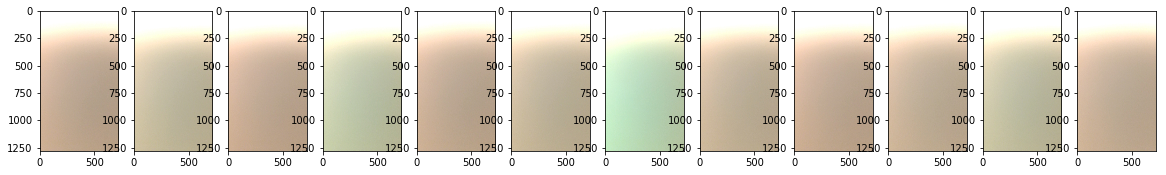

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_Sample3_Light_27-Mar-2019_12-26-41.pickle
Training_images/6S_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_12-26-41/Photos


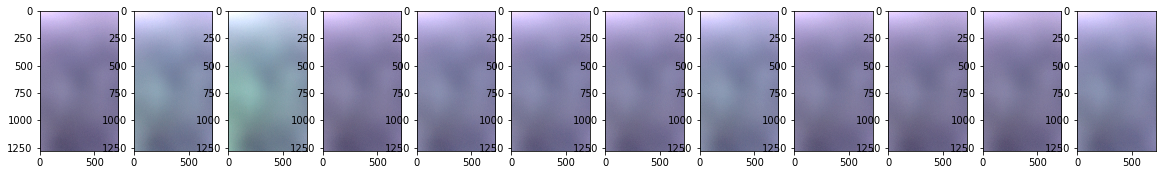

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_Sample3_Light_27-Mar-2019_13-11-00.pickle
Training_images/6S_Sample3_Light/ProtectCodeScannerResults_27-Mar-2019_13-11-00/Photos


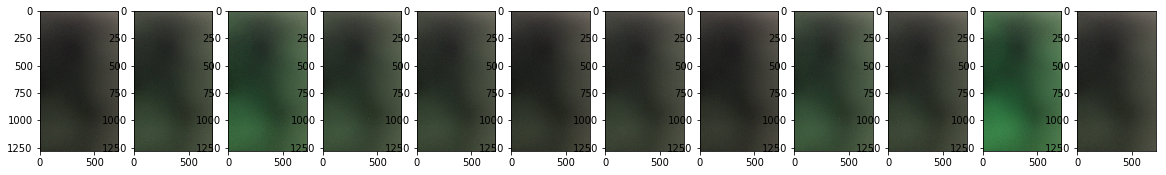

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_filledBottle_V_30-Oct-2019_11-17-07.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-17-07/Photos


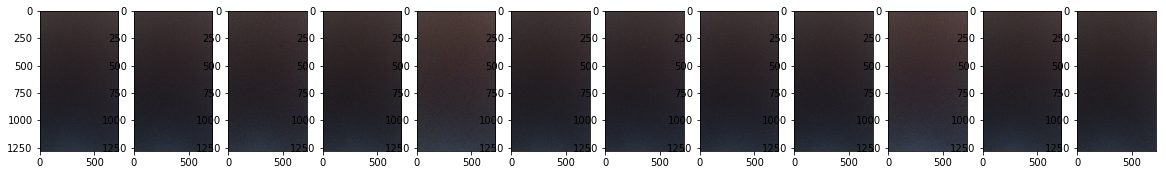

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_filledBottle_V_30-Oct-2019_11-25-41.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-25-41/Photos


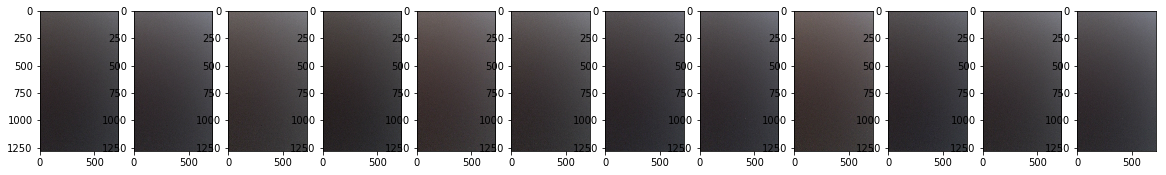

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_filledBottle_V_30-Oct-2019_11-37-44.pickle
30_10_62_original/6S_filledBottle_V/ProtectCodeScannerResults_30-Oct-2019_11-37-44/Photos


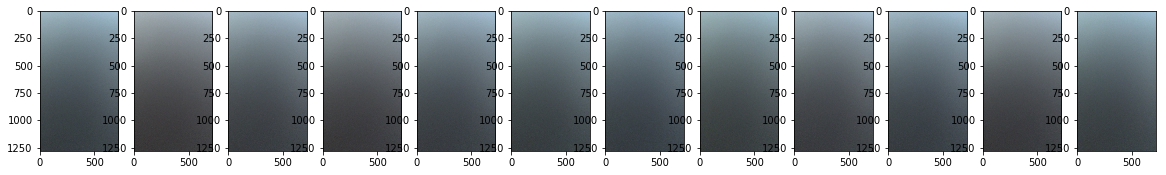

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_redBottle_H_29-Oct-2019_10-28-04.pickle
29_10_62_original/6S_redBottle_H/ProtectCodeScannerResults_29-Oct-2019_10-28-04/Photos


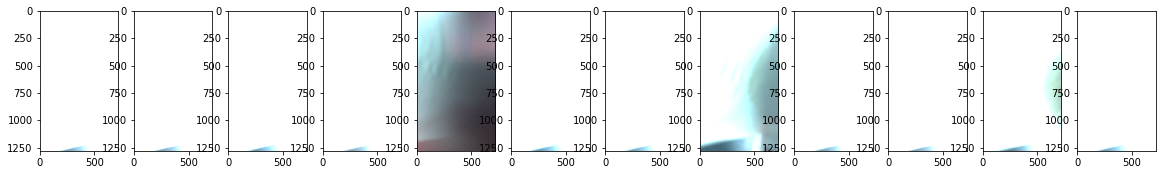

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_redBottle_H_29-Oct-2019_10-51-02.pickle
29_10_62_original/6S_redBottle_H/ProtectCodeScannerResults_29-Oct-2019_10-51-02/Photos


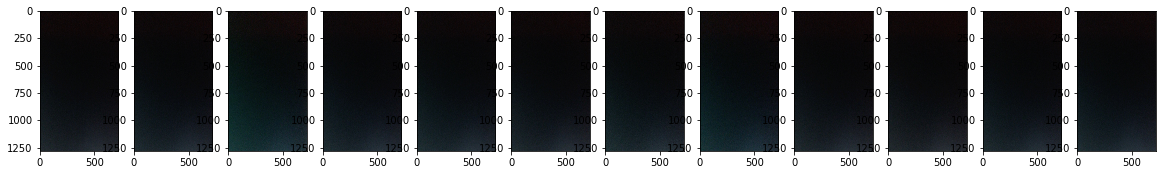

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_redBottle_V_30-Oct-2019_08-36-23.pickle
30_10_62_original/6S_redBottle_V/ProtectCodeScannerResults_30-Oct-2019_08-36-23/Photos


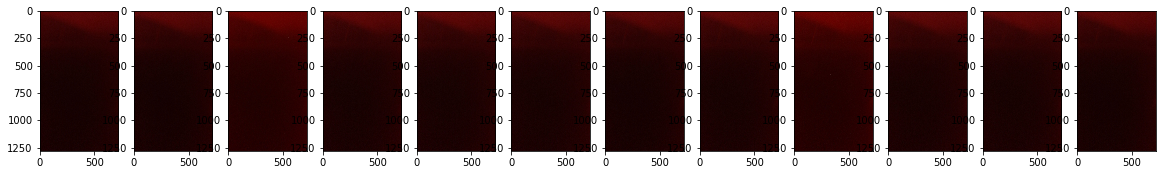

Split_Data_Bam1_combined_no_pillBottle/test/Present/6S_redBottle_V_30-Oct-2019_09-23-11.pickle
30_10_62_original/6S_redBottle_V/ProtectCodeScannerResults_30-Oct-2019_09-23-11/Photos


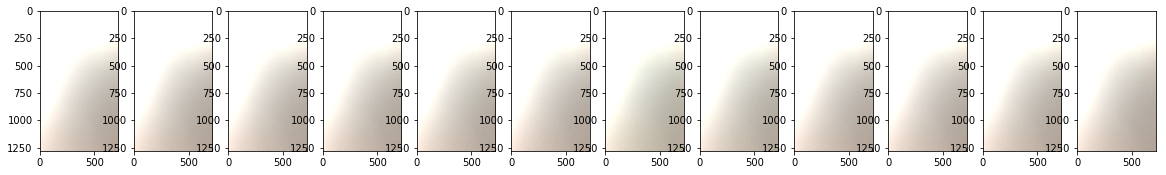

Split_Data_Bam1_combined_no_pillBottle/test/Present/7_Distance_and_Curved_13-Jun-2019_14-04-30.pickle
Training_images/7_Distance_and_Curved/ProtectCodeScannerResults_13-Jun-2019_14-04-30/Photos


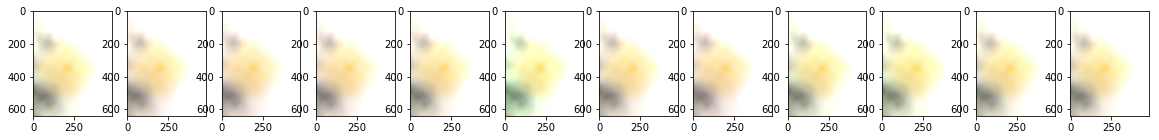

Split_Data_Bam1_combined_no_pillBottle/test/Present/7_Distance_and_Curved_13-Jun-2019_14-14-22.pickle
Training_images/7_Distance_and_Curved/ProtectCodeScannerResults_13-Jun-2019_14-14-22/Photos


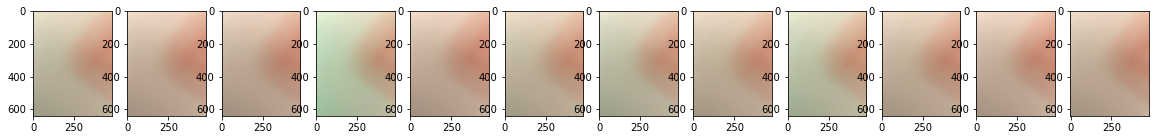

Split_Data_Bam1_combined_no_pillBottle/test/Present/7_Sample5_Light_27-Mar-2019_15-21-19.pickle
Training_images/7_Sample5_Light/ProtectCodeScannerResults_27-Mar-2019_15-21-19/Photos


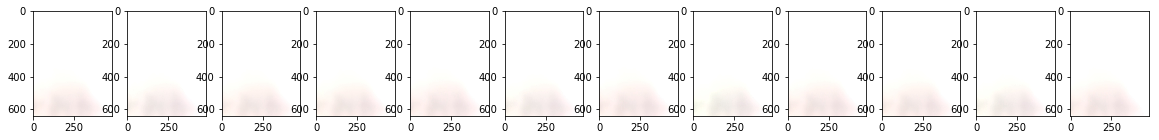

Split_Data_Bam1_combined_no_pillBottle/test/Present/SE_Sample3_Light_28-Mar-2019_15-50-04.pickle
Training_images/SE_Sample3_Light/ProtectCodeScannerResults_28-Mar-2019_15-50-04/Photos


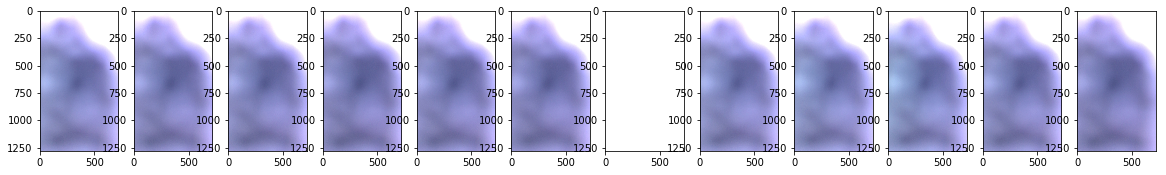

Split_Data_Bam1_combined_no_pillBottle/test/Present/SE_Sample5_Light_01-Apr-2019_16-00-12.pickle
Training_images/SE_Sample5_Light/ProtectCodeScannerResults_01-Apr-2019_16-00-12/Photos
error
Split_Data_Bam1_combined_no_pillBottle/test/Present/XS_Distance_and_Curved_13-Jun-2019_11-05-04.pickle
Training_images/XS_Distance_and_Curved/ProtectCodeScannerResults_13-Jun-2019_11-05-04/Photos


<Figure size 1440x2880 with 0 Axes>

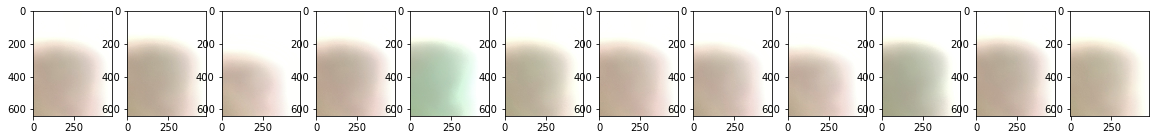

Split_Data_Bam1_combined_no_pillBottle/test/Present/XS_Distance_and_Curved_13-Jun-2019_11-16-05.pickle
Training_images/XS_Distance_and_Curved/ProtectCodeScannerResults_13-Jun-2019_11-16-05/Photos


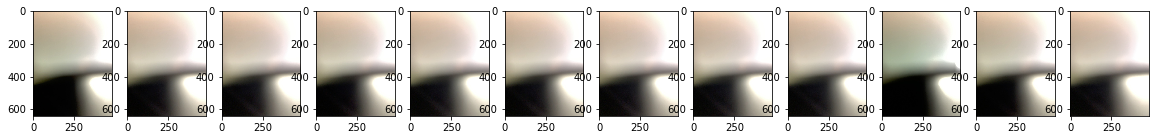

Split_Data_Bam1_combined_no_pillBottle/test/Present/XS_Distance_and_Curved_14-Jun-2019_11-19-32.pickle
Training_images/XS_Distance_and_Curved/ProtectCodeScannerResults_14-Jun-2019_11-19-32/Photos


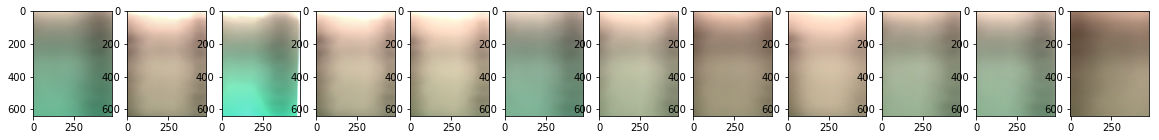

Split_Data_Bam1_combined_no_pillBottle/test/Present/XS_Distance_and_Curved_14-Jun-2019_11-27-02.pickle
Training_images/XS_Distance_and_Curved/ProtectCodeScannerResults_14-Jun-2019_11-27-02/Photos


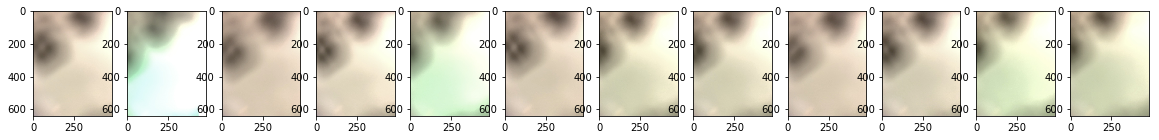

Split_Data_Bam1_combined_no_pillBottle/test/Present/XS_Distance_and_Curved_14-Jun-2019_11-35-21.pickle
Training_images/XS_Distance_and_Curved/ProtectCodeScannerResults_14-Jun-2019_11-35-21/Photos


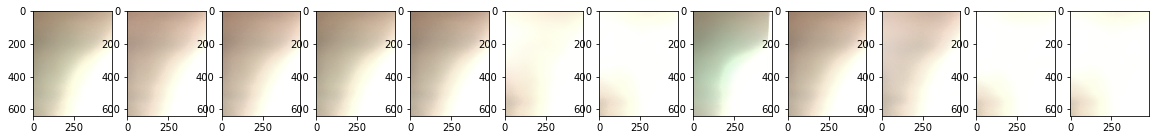

In [77]:
# View images that are false negatives
# print(false_neg_img)

top_folder = 'Training_images/'
basewidth = 100

for pickle_file in false_neg_img:
    print(pickle_file)
    if '30-Oct-2019' in pickle_file:
        top_folder = '30_10_62_original/'
    elif '29-Oct-2019' in pickle_file:
        top_folder = '29_10_62_original/'
    else: 
        top_folder = 'Training_images/'
    folder_and_file_name = pickle_file.split('/')[3]
    delimiter_bits = re.split("\w*_", folder_and_file_name) # my failed attempt to properly use regular expressions
    folder = folder_and_file_name.split(delimiter_bits[1])[0][:-1]
    datetime = delimiter_bits[1] + '2019_' + delimiter_bits[2].split('.pickle')[0]
    img_folder = top_folder + folder + '/ProtectCodeScannerResults_' + datetime + '/Photos'
    print(img_folder)
    try: 
        idx = 1
        plt.figure(figsize=(20,40))
        for img_file in os.listdir(img_folder):
            if img_file.endswith(".JPG"): 
                # print(img_folder + '/' + img_file)
                img = Image.open(img_folder + '/' + img_file)
                # wpercent = (basewidth/float(img.size[0]))
                # hsize = int((float(img.size[1])*float(wpercent)))
                # img = img.resize((basewidth,hsize), Image.ANTIALIAS)
                plt.subplot(1, 12, idx)
                plt.imshow(img)
                idx += 1
        plt.show()
    except:
        print('error')
        continue
      

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_Negative_Random_03-Jun-2019_14-15-57.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-15-57/Photos


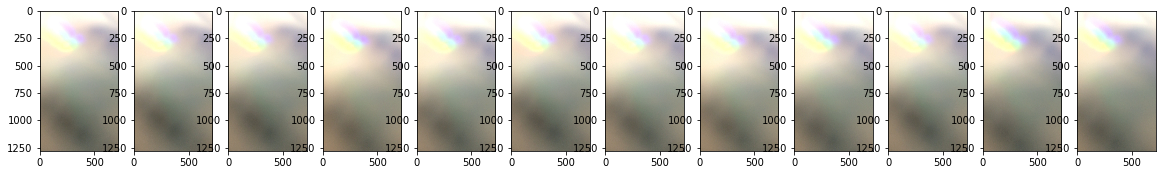

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_Negative_Random_03-Jun-2019_14-26-59.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-26-59/Photos


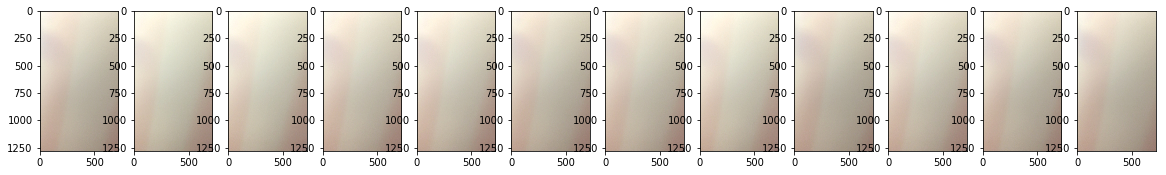

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_Negative_Random_03-Jun-2019_14-59-25.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-59-25/Photos


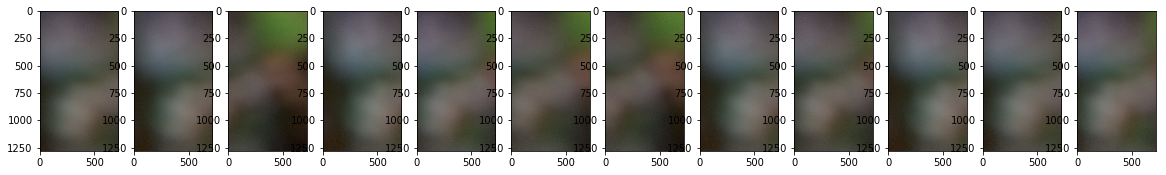

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_Negative_Random_03-Jun-2019_14-59-47.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_14-59-47/Photos


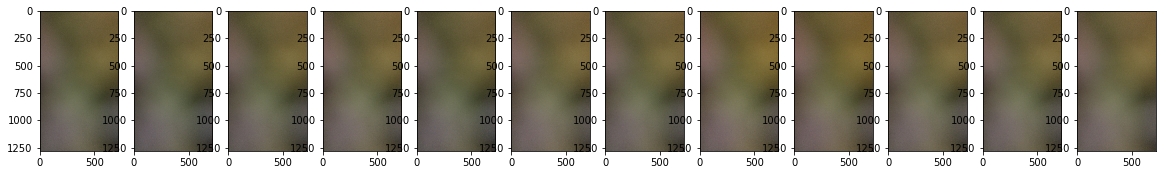

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_Negative_Random_03-Jun-2019_15-02-01.pickle
Training_images/6S_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_15-02-01/Photos


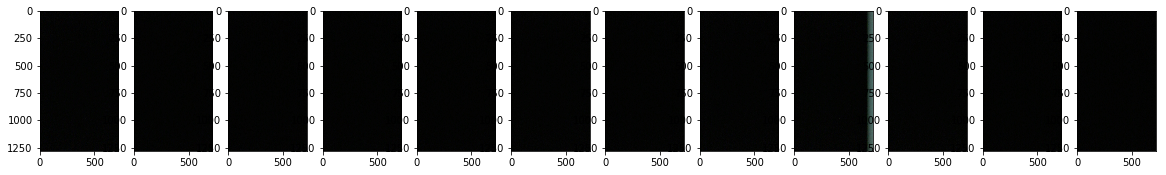

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_filledBottle_V_Negative_30-Oct-2019_16-02-04.pickle
30_10_62_original/6S_filledBottle_V_Negative/ProtectCodeScannerResults_30-Oct-2019_16-02-04/Photos


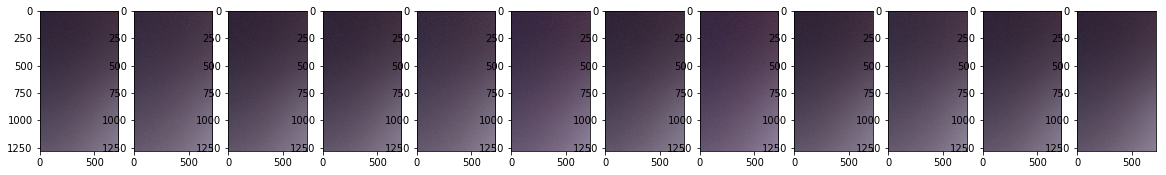

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_filledBottle_V_Negative_30-Oct-2019_16-02-36.pickle
30_10_62_original/6S_filledBottle_V_Negative/ProtectCodeScannerResults_30-Oct-2019_16-02-36/Photos


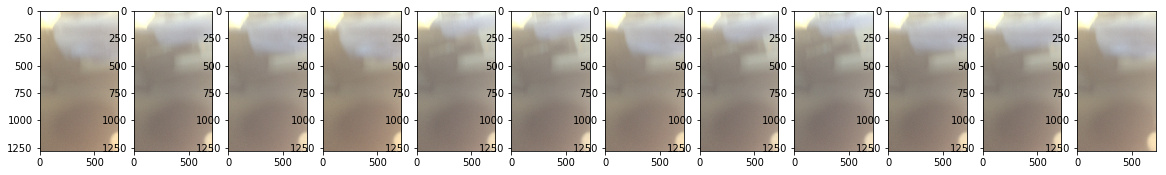

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_redBottle_H_Negative_29-Oct-2019_16-32-33.pickle
29_10_62_original/6S_redBottle_H_Negative/ProtectCodeScannerResults_29-Oct-2019_16-32-33/Photos


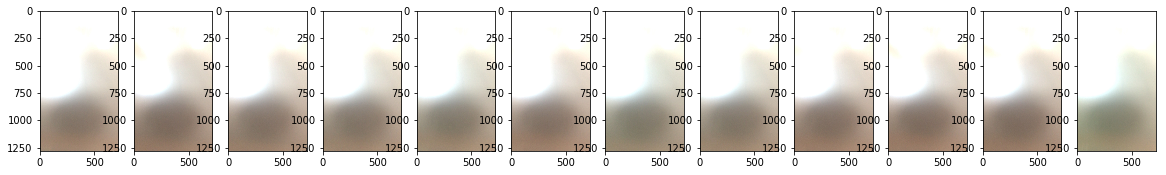

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_redBottle_V_Negative_30-Oct-2019_09-31-51.pickle
30_10_62_original/6S_redBottle_V_Negative/ProtectCodeScannerResults_30-Oct-2019_09-31-51/Photos


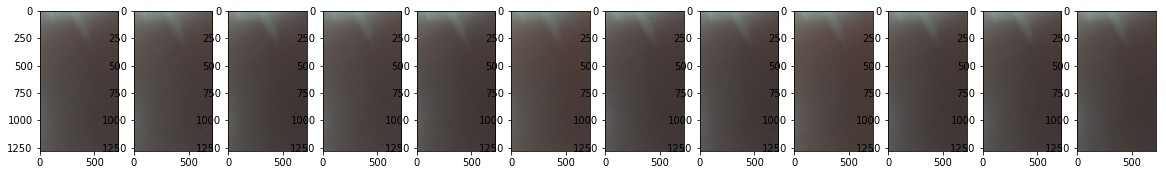

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6S_redBottle_V_Negative_30-Oct-2019_09-43-54.pickle
30_10_62_original/6S_redBottle_V_Negative/ProtectCodeScannerResults_30-Oct-2019_09-43-54/Photos


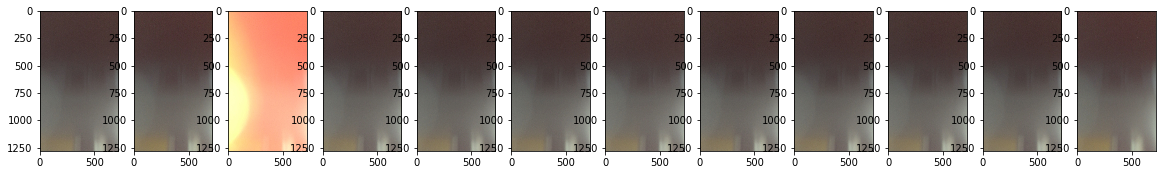

Split_Data_Bam1_combined_no_pillBottle/test/Absent/6_Negative_Random_03-Jun-2019_16-13-43.pickle
Training_images/6_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_16-13-43/Photos


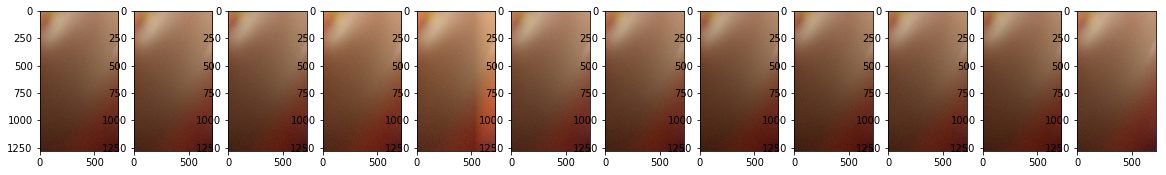

Split_Data_Bam1_combined_no_pillBottle/test/Absent/7_Negative_Random_30-May-2019_16-29-01.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_16-29-01/Photos


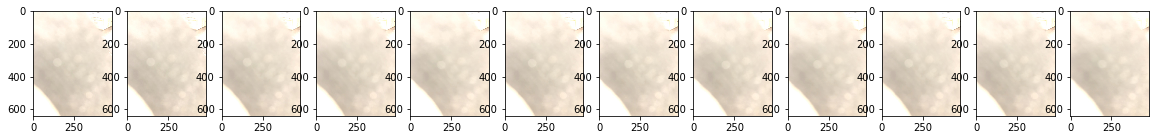

Split_Data_Bam1_combined_no_pillBottle/test/Absent/7_Negative_Random_30-May-2019_17-02-45.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-02-45/Photos


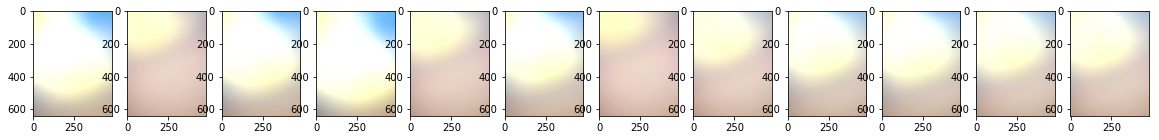

Split_Data_Bam1_combined_no_pillBottle/test/Absent/7_Negative_Random_30-May-2019_17-05-30.pickle
Training_images/7_Negative_Random/ProtectCodeScannerResults_30-May-2019_17-05-30/Photos


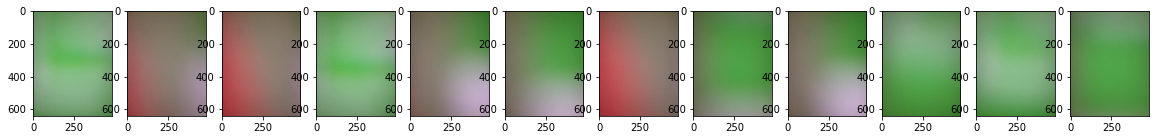

Split_Data_Bam1_combined_no_pillBottle/test/Absent/SE_Negative_Random_03-Jun-2019_17-04-36.pickle
Training_images/SE_Negative_Random/ProtectCodeScannerResults_03-Jun-2019_17-04-36/Photos


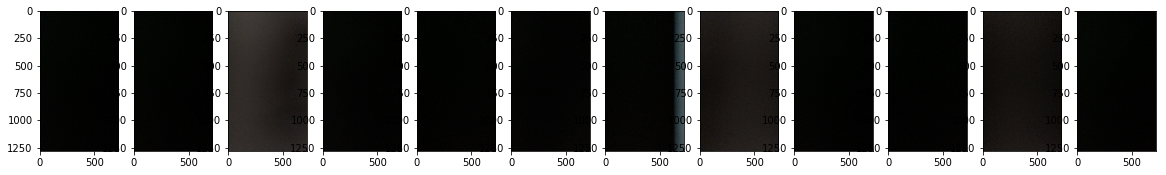

Split_Data_Bam1_combined_no_pillBottle/test/Absent/XS_Negative_Random_04-Jun-2019_10-26-44.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_04-Jun-2019_10-26-44/Photos
error
Split_Data_Bam1_combined_no_pillBottle/test/Absent/XS_Negative_Random_30-May-2019_14-33-45.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_30-May-2019_14-33-45/Photos
error
Split_Data_Bam1_combined_no_pillBottle/test/Absent/XS_Negative_Random_30-May-2019_15-36-27.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_30-May-2019_15-36-27/Photos
error
Split_Data_Bam1_combined_no_pillBottle/test/Absent/XS_Negative_Random_30-May-2019_15-45-22.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_30-May-2019_15-45-22/Photos
error
Split_Data_Bam1_combined_no_pillBottle/test/Absent/XS_Negative_Random_30-May-2019_15-51-41.pickle
Training_images/XS_Negative_Random/ProtectCodeScannerResults_30-May-2019_15-51-41/Photos
error


<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

<Figure size 1440x2880 with 0 Axes>

In [78]:
# View false positives
# print(false_pos_img)

# basewidth = 100

for pickle_file in false_pos_img:
    print(pickle_file)
    if '30-Oct-2019' in pickle_file:
        top_folder = '30_10_62_original/'
    elif '29-Oct-2019' in pickle_file:
        top_folder = '29_10_62_original/'
    else: 
        top_folder = 'Training_images/'
    folder_and_file_name = pickle_file.split('/')[3]
    delimiter_bits = re.split("\w*_", folder_and_file_name) # my failed attempt to properly use regular expressions
    folder = folder_and_file_name.split(delimiter_bits[1])[0][:-1]
    datetime = delimiter_bits[1] + '2019_' + delimiter_bits[2].split('.pickle')[0]
    img_folder = top_folder + folder + '/ProtectCodeScannerResults_' + datetime + '/Photos'
    print(img_folder)
    try: 
        idx = 1
        plt.figure(figsize=(20,40))
        for img_file in os.listdir(img_folder):
            if img_file.endswith(".JPG"): 
                # print(img_folder + '/' + img_file)
                img = Image.open(img_folder + '/' + img_file)
                # wpercent = (basewidth/float(img.size[0]))
                # hsize = int((float(img.size[1])*float(wpercent)))
                # img = img.resize((basewidth,hsize), Image.ANTIALIAS)
                plt.subplot(1, 12, idx)
                plt.imshow(img)
                idx += 1
        plt.show()
    except:
        print('error')
        continue

# Zip up state dict, get over to S3

In [90]:
# The below lines are only needed if allowing SageMaker to perform inference on the model.
# I can walk you through that when you get there.

#tarName = 'DNNModel_' + saveName + '.tar.gz' 

In [91]:
#os.system('tar -cvzf ' + tarName + ' ' + stateDictName)
#os.system('aws s3 cp ' + tarName + ' s3://ypb-ml-images/' + tarName)

0